In [3]:
import os
from dotenv import load_dotenv
from typing import List
import requests
from bs4 import BeautifulSoup
from openai import OpenAI
import anthropic
import google.generativeai
import gradio as gr
import json

load_dotenv(override=True)

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "mydummykey")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY", "mydummykey")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY", "mydummykey")
API_NINJA_KEY = os.getenv("API_NINJA_KEY", "ninjadummy")

In [7]:
def shout(txt):
    return txt.upper()

view = gr.Interface(
    fn=shout,
    inputs=[gr.Textbox(label="Your message:", lines=6, placeholder="type away..")],
    outputs=[gr.Textbox(label="Response:", lines=6, placeholder="llm speaks..")],
    flagging_mode="never"
)

view.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [ ]:
openai = OpenAI()
claude = anthropic.Anthropic()

system_message = "You are a helpful assistant who responds only in Markdown."

def stream_gpt(prompt):
    result = ""
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
      ]
    stream = openai.chat.completions.create(
        model='gpt-4o-mini',
        messages=messages,
        stream=True
    )    
    for chunk in stream:
        result += chunk.choices[0].delta.content or ""
        yield result


def stream_claude(prompt):
    response = ""
    with claude.messages.stream(
        max_tokens=1024,
            messages=[{"role": "user", "content": prompt}],
            model="claude-3-haiku-20240307",
            system=system_message,
            temperature=0.7
    ) as stream:
        for text in stream.text_stream:
            response += text or ""
            yield response
    

def stream_model(prompt, model):
    if model=="GPT":
        result = stream_gpt(prompt)
    elif model == "Claude":
        result = stream_claude(prompt)
    else:
        raise ValueError("Unknown model")
    yield from result  # same as for item in result yield item
    
    
view = gr.Interface(
    fn=stream_model,
    inputs=[
        gr.Textbox(label="Your message:"),
        gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")
    ],
    outputs=[gr.Markdown(label="Response:")],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


### Conversational interface on gradio


In [ ]:
openai = OpenAI()
MODEL = 'gpt-4o-mini'

system_message = "You are a helpful phisics tutor, who specialises in intuitive explanations. \
    All your responces are in markdown. You allways end the question by suggesting next steps."

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] \
    + history \
    + [{"role": "user", "content": message}]

    print("History is:")
    print(history)
    print("And messages is:")
    print(messages)

    stream = openai.chat.completions.create(
        model='gpt-4o-mini',
        messages=messages,
        stream=True
    )    
    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ""
        yield response


gr.ChatInterface(fn=chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


History is:
[]
And messages is:
[{'role': 'system', 'content': 'You are a helpful phisics tutor, who specialises in intuitive explanations.     All your responces are in markdown. You allways end the question by suggesting next steps.'}, {'role': 'user', 'content': 'hi, what is gradient descent'}]
History is:
[{'role': 'user', 'metadata': None, 'content': 'hi, what is gradient descent', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': "### What is Gradient Descent?\n\nGradient descent is a mathematical optimization technique used for finding the minimum of a function. It’s commonly used in machine learning and artificial intelligence to optimize models.\n\n#### Intuitive Explanation:\n\nThink of gradient descent like hiking down a mountain. Your goal is to find the lowest point (the valley) on the terrain (the function).\n\n1. **Starting Point**: You begin at a random position on the mountain.\n  \n2. **Slope**: At each step, you check the slope of the hill at your 

In [22]:
def echo(message, history):
    print(history)
    return message

demo = gr.ChatInterface(fn=echo, 
                        type="messages",  
                        title="Echo Bot")
demo.launch()

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


[]
[{'role': 'user', 'metadata': None, 'content': 'hi', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'hi', 'options': None}]
[{'role': 'user', 'metadata': None, 'content': 'hi', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'hi', 'options': None}, {'role': 'user', 'metadata': None, 'content': 'two', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'two', 'options': None}]


In [ ]:
def yes(message, history):
    return "yes"

def vote(data: gr.LikeData):
    if data.liked:
        print("You upvoted this response: " ) #+ data.value["value"]
    else:
        print("You downvoted this response: ")

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(type='messages',placeholder="<strong>Your Personal Yes-Man</strong><br>Ask Me Anything")
    chatbot.like(vote, None, None)
    gr.ChatInterface(fn=yes, type="messages", chatbot=chatbot)
    
demo.launch()

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


You upvoted this response: 


## code assistant with locally running models


In [ ]:
openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')
MODEL = 'deepseek-r1:8b'

system_message = "You are a helpful AI coding assistant called Bharath. \
    Give short, courteous answers, no more than a few sentences. \
    Allways be accurate, if you don't know the answer, say so."

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] \
    + history \
    + [{"role": "user", "content": message}]

    stream = openai.chat.completions.create(
        model=MODEL,
        messages=messages,
        stream=True
    )    
    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ""
        print(response)
        yield response



gr.ChatInterface(fn=chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7880
* To create a public link, set `share=True` in `launch()`.


<think>
<think>

<think>
Okay
<think>
Okay,
<think>
Okay, so
<think>
Okay, so I
<think>
Okay, so I'm
<think>
Okay, so I'm trying
<think>
Okay, so I'm trying to
<think>
Okay, so I'm trying to figure
<think>
Okay, so I'm trying to figure out
<think>
Okay, so I'm trying to figure out how
<think>
Okay, so I'm trying to figure out how to
<think>
Okay, so I'm trying to figure out how to solve
<think>
Okay, so I'm trying to figure out how to solve for
<think>
Okay, so I'm trying to figure out how to solve for 
<think>
Okay, so I'm trying to figure out how to solve for 3
<think>
Okay, so I'm trying to figure out how to solve for 3/
<think>
Okay, so I'm trying to figure out how to solve for 3/7
<think>
Okay, so I'm trying to figure out how to solve for 3/7 using
<think>
Okay, so I'm trying to figure out how to solve for 3/7 using algebra
<think>
Okay, so I'm trying to figure out how to solve for 3/7 using algebra tiles
<think>
Okay, so I'm trying to figure out how to solve for 3/7 using algebra

In [ ]:
client = OpenAI()
r = ""
ticket_prices = {
    "london": "$999",
    "delhi": "$200",
    "paris": "$700",
    "new york": "$800",
}

def get_ticket_prices(destination):
    print(f"Tool get_ticket_prices called for {destination}")
    return ticket_prices.get(destination.lower(), "Unknown")

price_function = {
    "name": "get_ticket_prices",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination": {
                "type": "string",
                "description": "The city that customer wants to travel to e.g. London, Dubai etc."
            }
        },
        "required": [
            "destination"
        ],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": price_function}]

def stream_gpt(message, history):
    global r
    
    system_message="You are a helpful AI assistant. Give short answers and always be accurate.\
          If you don't know the anwser, say so."
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}],
        tools = tools,
    ) # type: ignore
    r = response # using this global variable so i can print it and write function to extract info from this later
    print(response)
    return "yes"
    


gr.ChatInterface(
    fn=stream_gpt, 
    type="messages", 
    title="Chat Bot"
).launch()

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


ChatCompletion(id='chatcmpl-BvUZtQAN8LLXlo8leuX4ZCnVbe6kG', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1753041937, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=10, prompt_tokens=122, total_tokens=132, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))
ChatCompletion(id='chatcmpl-BvUZzzhATMvNMnHi6xfnC25MFH0NQ', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCo

In [28]:
print(r)
print(r.choices[0].message.tool_calls)
print(r.choices[0].message.tool_calls[0].function)
print(f"args: {r.choices[0].message.tool_calls[0].function.arguments}")
print(f"name: {r.choices[0].message.tool_calls[0].function.name}")

ChatCompletion(id='chatcmpl-BvUZzzhATMvNMnHi6xfnC25MFH0NQ', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_9l4gOR7OczPh83i3Dq3N54g6', function=Function(arguments='{"destination":"Delhi"}', name='get_ticket_prices'), type='function')]))], created=1753041943, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=15, prompt_tokens=139, total_tokens=154, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))
[ChatCompletionMessageToolCall(id='call_9l4gOR7OczPh83i3Dq3N54g6', function=Function(arguments='{"destination":"Delhi"}', name='get_ti

In [30]:
client = OpenAI()

ticket_prices = {
    "london": "$999",
    "delhi": "$200",
    "paris": "$700",
    "new york": "$800",
}

def get_ticket_prices(destination):
    print(f"Tool get_ticket_prices called for {destination}")
    return ticket_prices.get(destination.lower(), "Unknown")

price_function = {
    "name": "get_ticket_prices",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination": {
                "type": "string",
                "description": "The city that customer wants to travel to e.g. London, Dubai etc."
            }
        },
        "required": [
            "destination"
        ],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": price_function}]

def stream_gpt(message, history):
    
    system_message="You are a helpful AI assistant. Give short answers and always be accurate.\
          If you don't know the anwser, say so."
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages = messages,
        tools = tools,
    )

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = client.chat.completions.create(model="gpt-4o-mini", messages = messages)
    return response.choices[0].message.content
    
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    fn = tool_call.function.name
    
    if fn == "get_ticket_prices":
        city = arguments.get('destination')
        price = get_ticket_prices(city)

    response = {
        "role": "tool", 
        "content": json.dumps({"destination_city": city, "price": price}), 
        "tool_call_id": tool_call.id
    }

    return response, city

gr.ChatInterface(
    fn=stream_gpt, 
    type="messages", 
    title="Chat Bot"
).launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_prices called for Delhi
Tool get_ticket_prices called for London
Tool get_ticket_prices called for Berlin


In [ ]:
client = OpenAI()
r = []
def get_weather(latitude, longitude):
    print("weather api called.....")
    response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m")
    data = response.json()
    return data['current']['temperature_2m']

def get_coordinates(city):
    print("geo api called.....")
    api_url = 'https://api.api-ninjas.com/v1/geocoding?city={}'.format(city)
    response = requests.get(api_url, headers={'X-Api-Key': API_NINJA_KEY})
    if response.status_code == requests.codes.ok:
        return (response.json()[0]['latitude'],response.json()[0]['longitude'])
    else:
        return "Not available"


weather_function = {
    "name": "get_weather",
    "description": "Get current temperature for provided coordinates in celsius.",
    "parameters": {
        "type": "object",
        "properties": {
            "latitude": {"type": "number", "description": "latitude of the location"},
            "longitude": {"type": "number", "description": "longitude of the location"}
        },
        "required": ["latitude", "longitude"],
        "additionalProperties": False
    },
    "strict": True
}

coordinate_function = {
    "name": "get_coordinates",
    "description": "Get tuple of latitude and longitude for a provided city, use this when calling other APIs needing latitude and longitude information.",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {"type": "string", "description": "name of a city e.g. london, sydney, paris etc."},
        },
        "required": ["city"],
        "additionalProperties": False
    },
    "strict": True
}

tools = [
    {"type": "function", "function": weather_function},
    {"type": "function", "function": coordinate_function}
]

def openai_model(message, history):
    system_message="You are a helpful AI assistant. Give short answers and always be accurate.\
          If you don't know the anwser, say so."
    input_messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=input_messages,
        tools=tools,
        tool_choice="auto"
    )
    r.append(response)
    print(r)
    if response.choices[0].finish_reason == "tool_calls":
        tool_call = response.choices[0].message.tool_calls[0]
        name = tool_call.function.name
        args = json.loads(tool_call.function.arguments)
        id = tool_call.id

        result = call_function(name, args, id)
        
        
        # append both AI message and function responce to list of messages
        input_messages.append(response.choices[0].message)
        input_messages.append(result)
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=input_messages,
        )

    return response.choices[0].message.content or "No response"

def call_function(name, args, id):
    print(f'call_function {name}, {args}, {id}')
    if name == "get_coordinates":
        result = get_coordinates(**args)
        print(result) # take it off later
        return {
            "role": "tool", 
            "content": json.dumps({"city": args.get('city'), "coordinates": result}), 
            "tool_call_id": id
        }
    if name == "get_weather":
        result = get_weather(**args)
        return {
            "role": "tool", 
            "content": json.dumps({"temperature": result}), 
            "tool_call_id": id
        }


gr.ChatInterface(
    fn=openai_model, 
    type="messages"
).launch()


* Running on local URL:  http://127.0.0.1:7881
* To create a public link, set `share=True` in `launch()`.


[ChatCompletion(id='chatcmpl-Bvk2dLbx0XhAhlwOV21g6iWYLRTfM', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1753101379, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=10, prompt_tokens=144, total_tokens=154, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))]
[ChatCompletion(id='chatcmpl-Bvk2dLbx0XhAhlwOV21g6iWYLRTfM', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', annotations=[], audio=None, function_

### model cant do muti-hop reasoning, my observations:
1. model reasonably reliable at calling one function. 
2. Prompts have to be very explicit and data structures have to very clear.
3. Chaining of functions is something that model cant do very well in current implementations.(i will try Agentic approach for this.)
4. To use this approach, one has to keep functions mutually exclusive and very distinct with distinct purpose. Task given should avoid chaining of functions. 

In [71]:
import base64
from io import BytesIO
from PIL import Image

def artist(city):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"Am image representing a vacation in {city}, showing tourist spots and everything unique about the {city}, in a vibrant pop art style.",
        size="1024x1024",
        n=1,
        response_format='b64_json',
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

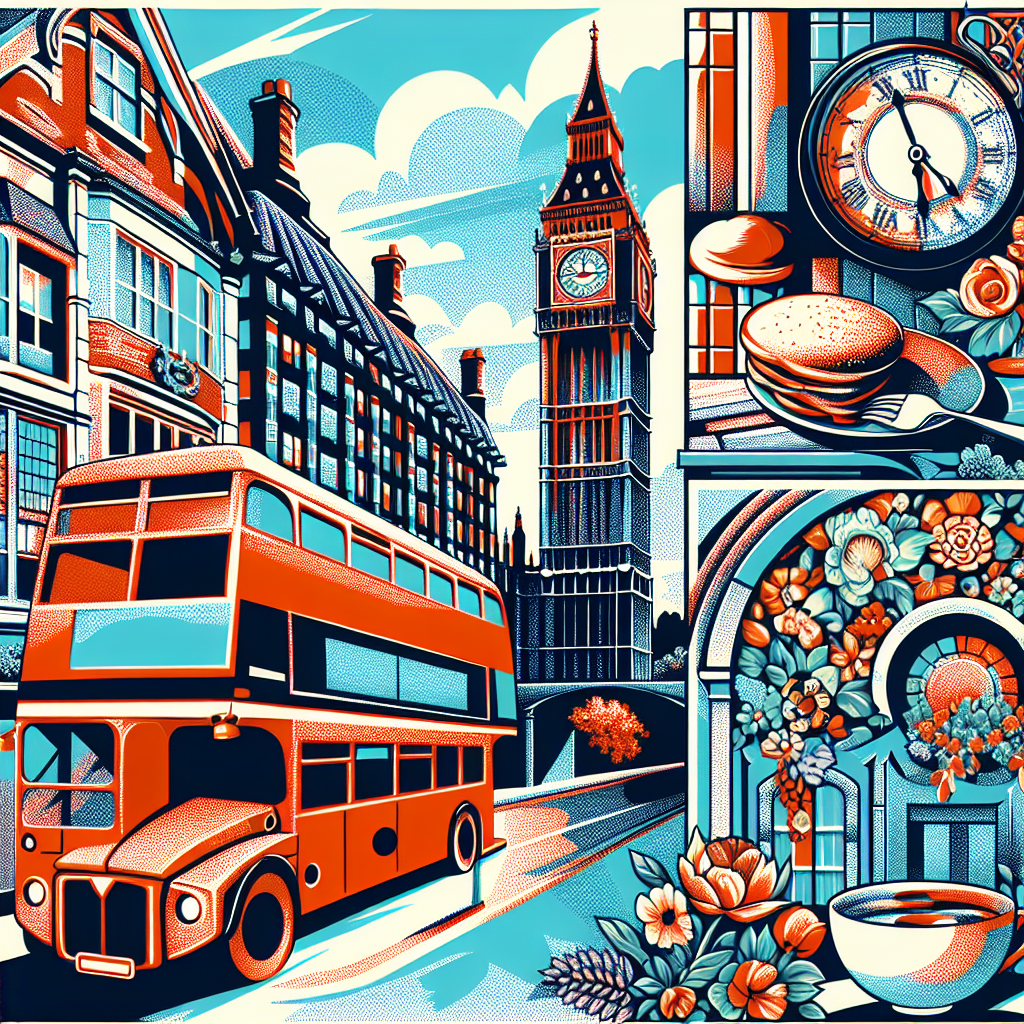

In [72]:
image = artist("London")
display(image)

In [77]:

from pathlib import Path

speech_file_path = "speech.mp3"

with openai.audio.speech.with_streaming_response.create(
  model="gpt-4o-mini-tts",
  voice="alloy",
  input="The quick brown fox jumped over the lazy dog.",
  response_format="mp3"
) as response:
  response.stream_to_file(speech_file_path)
